# Ensemble of binned heteroskedastic deep neural networks

In [3]:
import jax
import optax
import distrax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from tqdm.notebook import tqdm
from flax.core import freeze
from functools import partial
from dynamax.utils import datasets
from rebayes import batch_sgd as bsgd
from jax.flatten_util import ravel_pytree
from flax.training.train_state import TrainState

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [5]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [81]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [98]:
tfd.Dirichlet(jnp.array([4.0, 2, 4])).log_prob(jnp.array([0.1, 0.4, 0.5]))

Array(-0.6856909, dtype=float32)

## The model

In [666]:
class MLP(nn.Module):
    dim_out: int
    activation: Callable = nn.relu
        
    @nn.compact
    def __call__(self, x):
        # Shared components
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        mean = nn.Dense(self.dim_out, name="mean")(x)
        return mean

@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    alphav = applyfn(params, X).squeeze()
    alphav = jnp.log(jax.nn.softmax(alphav))
    
    params_flat, _ = ravel_pytree(params)
    priors = distrax.Normal(loc=0, scale=1.0).log_prob(params_flat).sum()

    likelihood = -(alphav * y).sum(axis=1).sum()
    neg_potential = -priors + likelihood
    return likelihood / 1000

In [667]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

## Rotating MNIST

## Setup

In [668]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=1, maxangle=180)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)


# X_train = X_train.reshape(-1, 28, 28)
# X_test = X_test.reshape(-1, 28, 28)
num_train, *dim_input = X_train.shape

# Introducing trenches
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

y_train = y_train[map_trench]
X_train = X_train[map_trench]

In [669]:
n_bins = 20
kernel = jnp.array([0.1, 0.2, 0.4, 0.2, 0.1])

bins = jnp.linspace(0, 180, n_bins)
y_train_bins = jnp.digitize(y_train, bins)
y_train_ohe = jax.nn.one_hot(y_train_bins, n_bins)

y_train_ohe = jax.vmap(jnp.convolve, (0, None, None))(y_train_ohe, kernel, "same")
y_train_ohe = y_train_ohe / y_train_ohe.sum(axis=1, keepdims=True)

In [670]:
y_test_bins = jnp.digitize(y_test, bins)
y_test_ohe = jax.nn.one_hot(y_test_bins, n_bins)

y_test_ohe = jax.vmap(jnp.convolve, (0, None, None))(y_test_ohe, kernel, "same")
y_test_ohe = y_test_ohe / y_test_ohe.sum(axis=1, keepdims=True)

In [671]:
batch_size = 100
batch = (batch_size, *dim_input)
model = MLP(n_bins, activation=nn.elu)
batch = jnp.ones(batch)
params_init = model.init(key_init, batch)

### Training

In [672]:
num_epochs = 5_000
batch_size = 500
keys_train = jax.random.split(key_train, num_epochs)
loss_grad = jax.value_and_grad(lossfn, 0)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(5e-6)
)

losses = []
crossval = []

elements  = list(enumerate(keys_train))
pbar = tqdm(elements)
for (e, key) in pbar:
    loss, state, = bsgd.train_epoch(key, batch_size, state, X_train, y_train_ohe, loss_grad)
    losses.append(loss.item())
    
    xv_test = lossfn(state.params, X_test, y_test_ohe, state.apply_fn)
    crossval.append(xv_test.item())

    losstr = f"{loss:0.4e}"
    pbar.set_description(losstr)

  0%|          | 0/5000 [00:00<?, ?it/s]

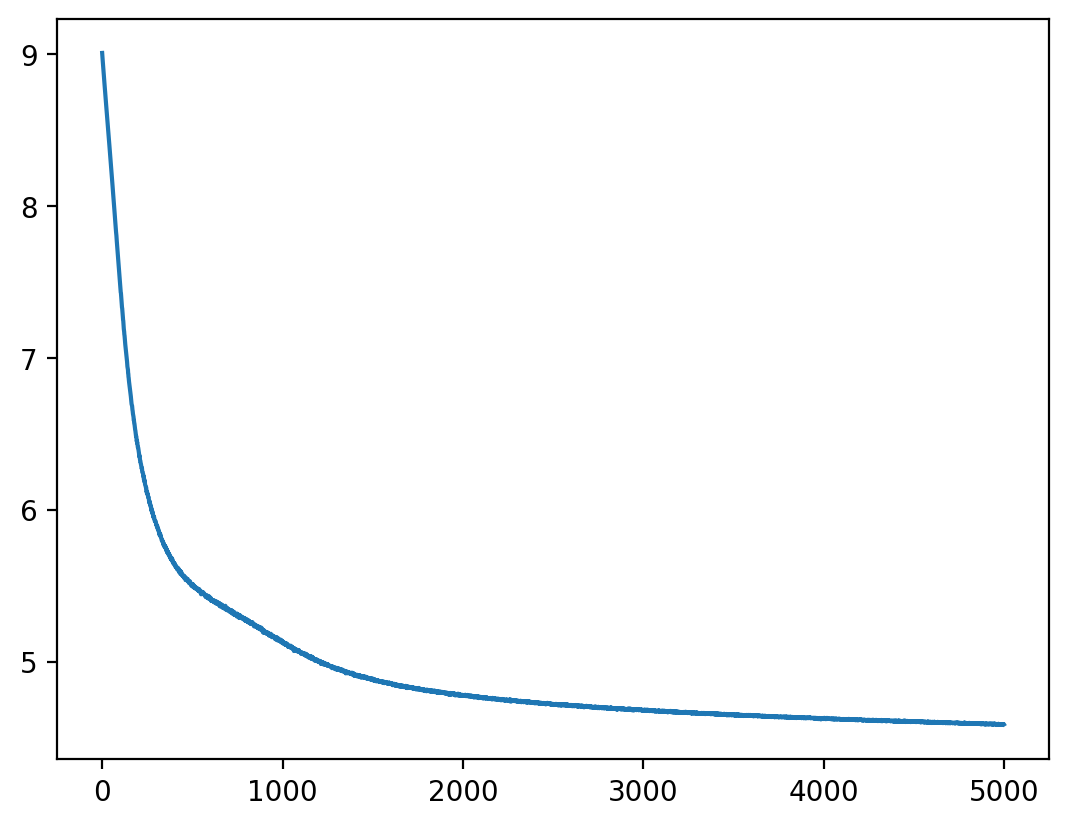

In [673]:
plt.plot(losses)
# plt.yscale("log")

In [674]:
logits_test = state.apply_fn(state.params, X_test)
probs_test = jax.nn.softmax(logits_test, axis=1)

(-9.0, 189.0)

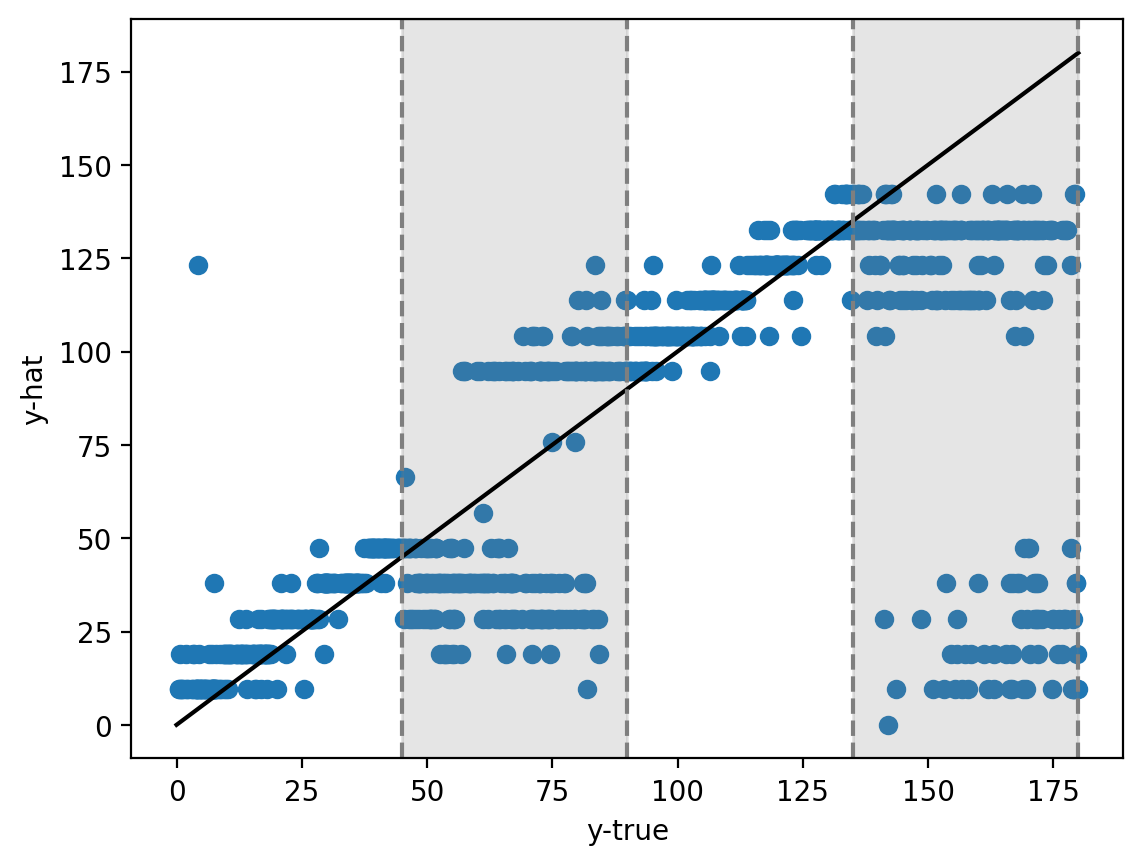

In [675]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)
vmin, vmax = y_test.min(), y_test.max()

plt.scatter(y_test, bins[probs_test.argmax(axis=1)])
plt.plot([0, 180], [0, 180], c="black")
plt.ylabel("y-hat")
plt.xlabel("y-true")


# Trenches
ymin, ymax = plt.ylim()
plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")
plt.ylim(ymin, ymax)

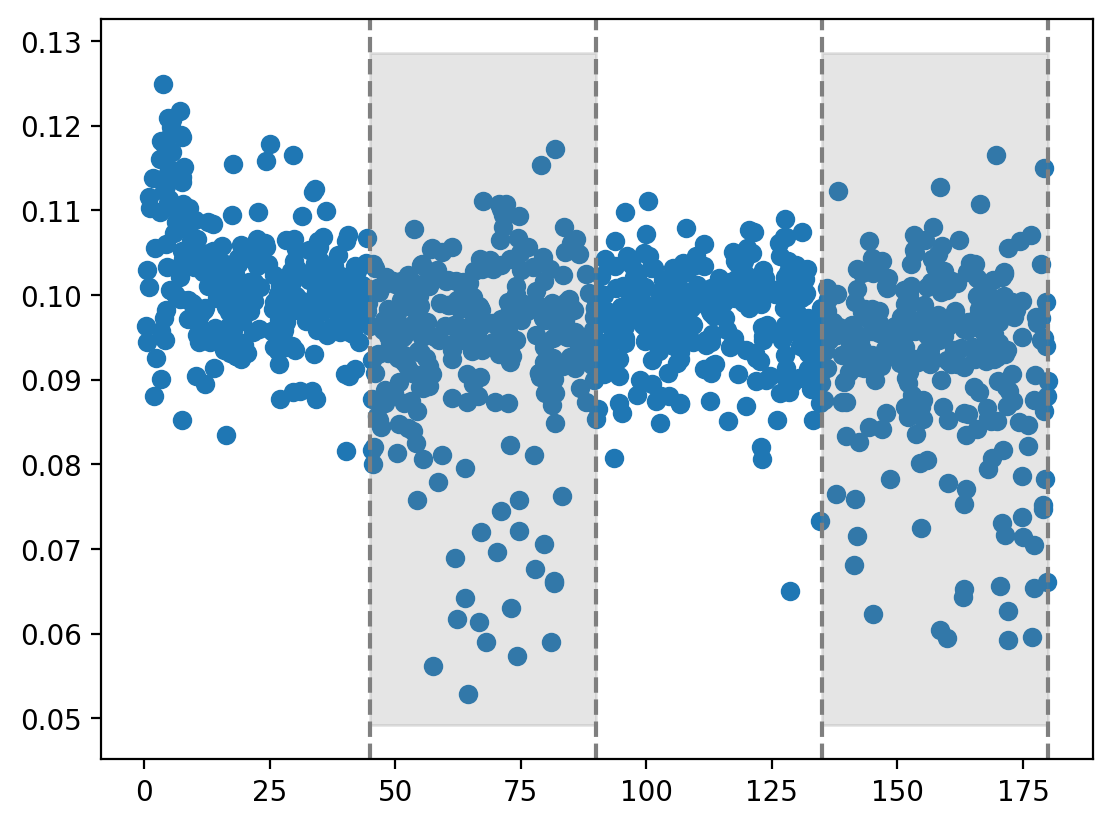

In [676]:
ix_sort = jnp.argsort(y_test)
plt.scatter(y_test[ix_sort], probs_test.std(axis=1)[ix_sort])
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

In [677]:
ix_target = 0
x_target = np.array(X_test[ix_target]).reshape(28, 28)
y_init = float(y_test[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

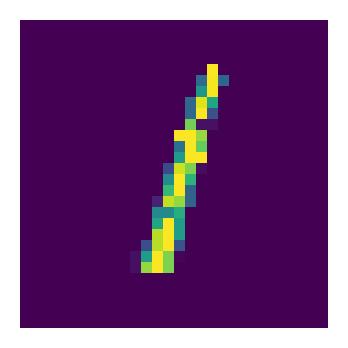

In [678]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_target.reshape(28, 28))
ax.axis("off");

In [679]:
n_rotations = 1000
rotations = np.linspace(0, 360, n_rotations)
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 360, 100)

In [680]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

In [681]:
logits_test = state.apply_fn(state.params, X_target)
probs_test = jax.nn.softmax(logits_test, axis=1)

(-10.0, 190.0)

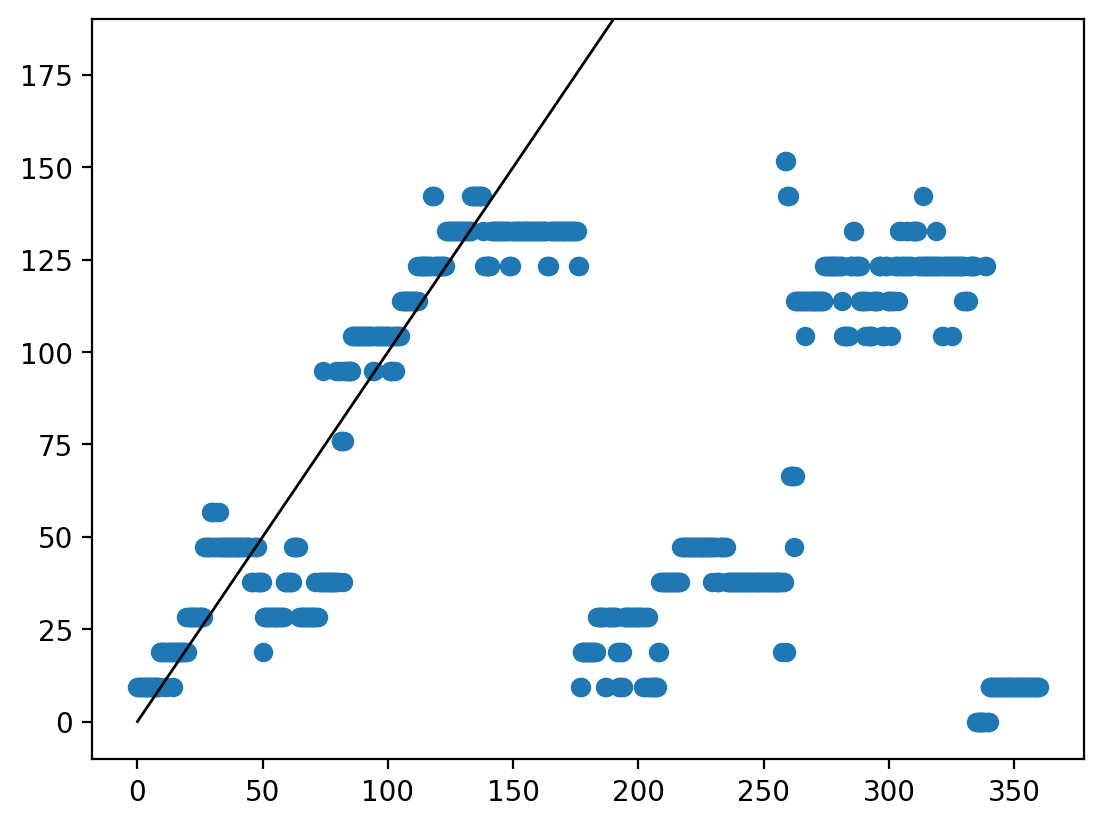

In [682]:
plt.scatter(y_target, bins[probs_test.argmax(axis=1)])
plt.plot([0, 360], [0, 360], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.ylim(-10, 190)

## Ensemble

In [683]:
def create_train_state(params):
    state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optax.adam(1e-6)
    )
    return state


def step_train_adversarial(state, key):
    # Train step according to adversarial example
    key_adv, key_r, key_train = jax.random.split(key, 3)
    loss_jac = jax.grad(lossfn, 1)
    jacs = loss_jac(state.params, X_train, y_train_ohe, state.apply_fn)
    jacsign = jnp.sign(jacs)
    
    perturb = jax.random.normal(key_adv, jacsign.shape)
    perturb = perturb / jnp.linalg.norm(perturb, axis=1, keepdims=True)
    r = jax.random.normal(key_r)
    
    X_adv = X_train + jacsign * perturb * r
    
    loss, state, = bsgd.train_epoch(key_train, batch_size, state, X_adv, y_train_ohe, loss_grad)
    return state, loss



def step_train(state, key):
    loss, state, = bsgd.train_epoch(key, batch_size, state, X_train, y_train_ohe, loss_grad)
    # xv_test = lossfn(state.params, X_test, y_test, state.apply_fn)    
    return state, loss


def init_and_train(key):
    num_epochs = 5_000
    key_init, key_train = jax.random.split(key)
    keys_train = jax.random.split(key_train, num_epochs)

    key_params, key_std = jax.random.split(key_init)
    params = model.init(key_params, batch)
    
    state = create_train_state(params)
    state, crossval = jax.lax.scan(step_train_adversarial, state, keys_train)
    return state, crossval

## Train ensemble

In [684]:
%%time
size_ensemble = 25
key_vtrain = jax.random.split(key, size_ensemble)
state, crossval = jax.vmap(init_and_train)(key_vtrain)
crossval = jax.block_until_ready(crossval)

CPU times: user 1min 37s, sys: 10.9 s, total: 1min 47s
Wall time: 4min 39s


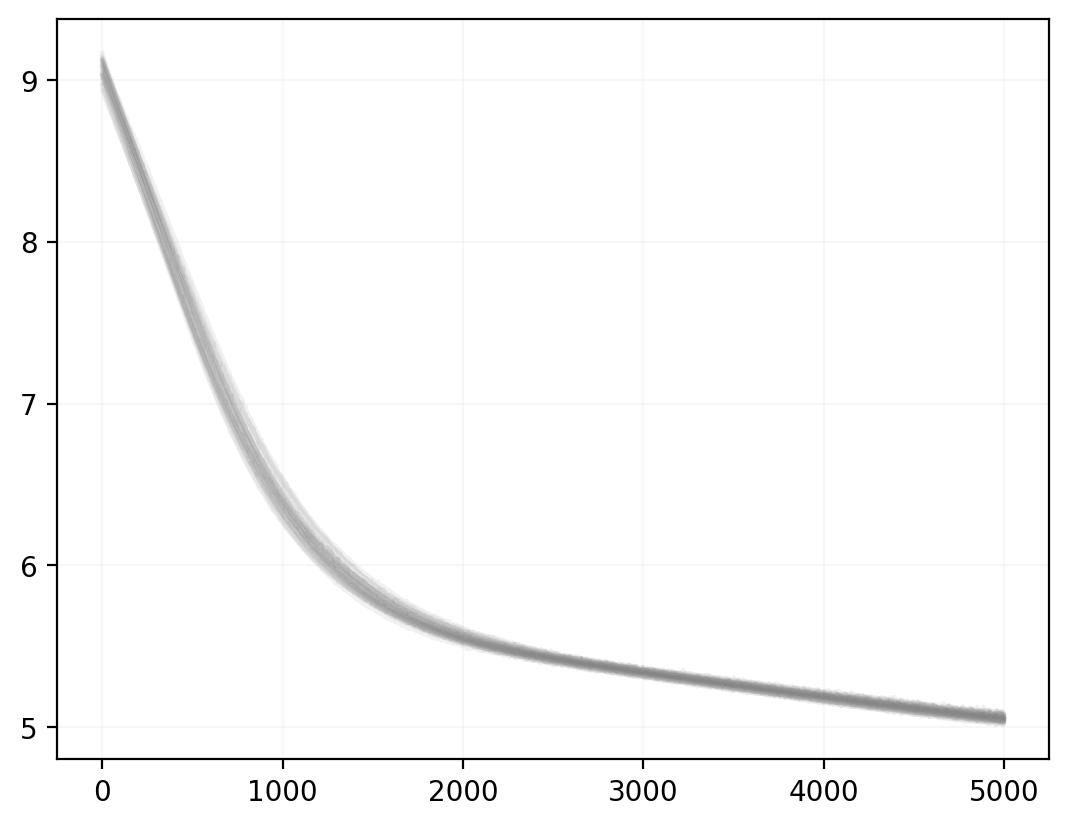

In [685]:
plt.plot(crossval.T, c="tab:gray", alpha=0.1)
# plt.yscale("log")
plt.grid(alpha=0.09)

In [686]:
logits_test = jax.vmap(state.apply_fn, (0, None))(state.params, X_test)
probs_test = jax.nn.softmax(logits_test, axis=-1)
probs_test.shape

(25, 1135, 20)

In [687]:
yhat_test = bins[probs_test.argmax(axis=-1)].mean(axis=0)
yhat_std = bins[probs_test.argmax(axis=-1)].std(axis=0)

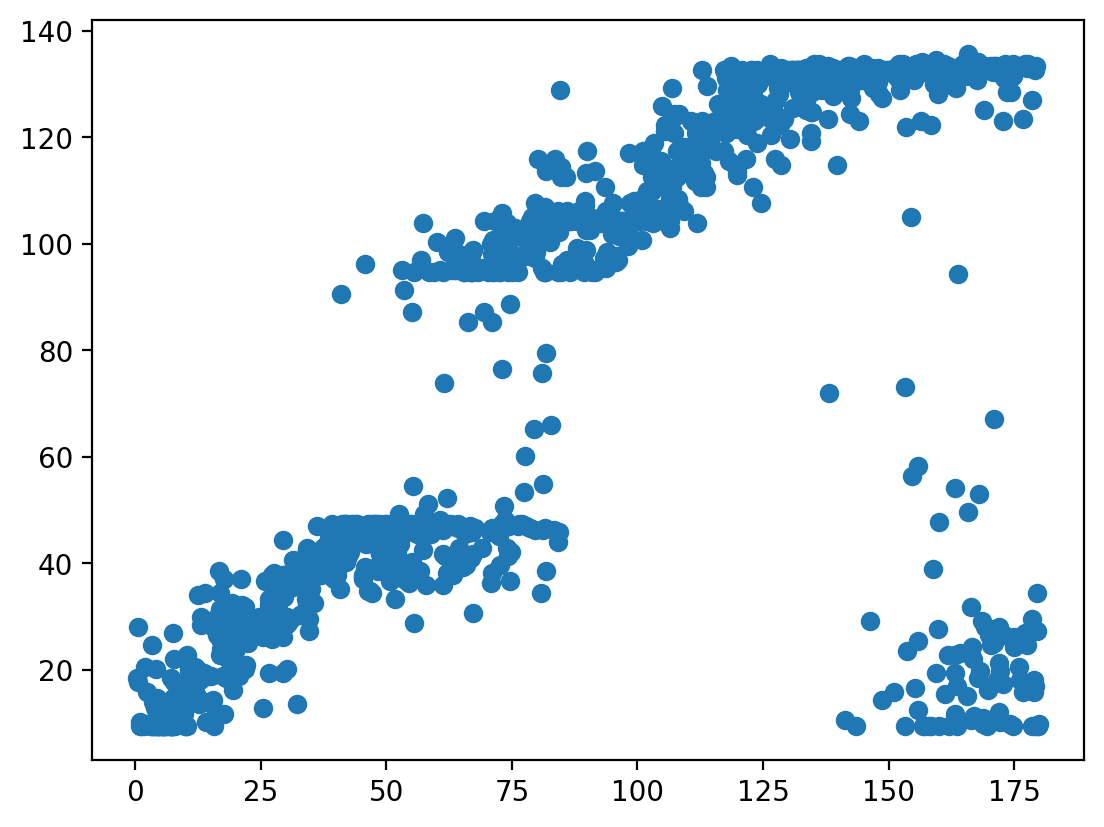

In [688]:
plt.scatter(y_test, yhat_test)

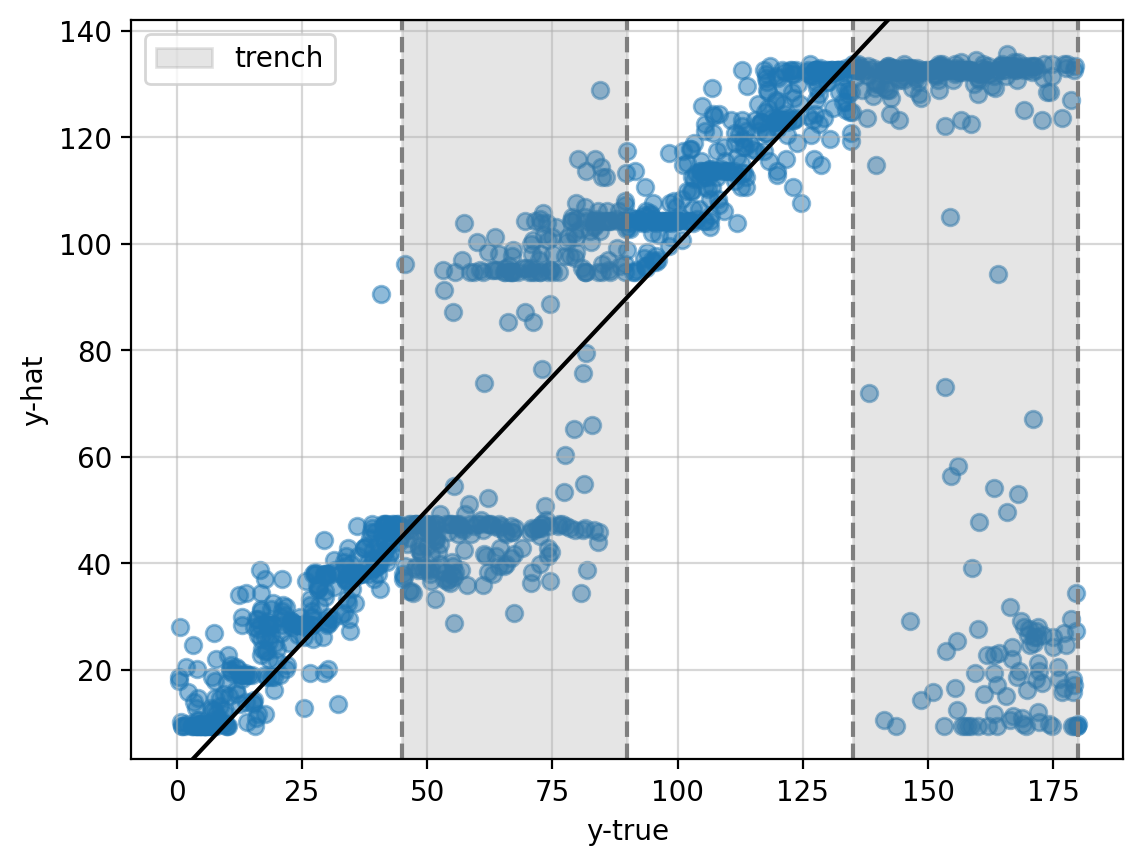

In [689]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

plt.scatter(y_test, yhat_test, alpha=0.5, edgecolors=None)

plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

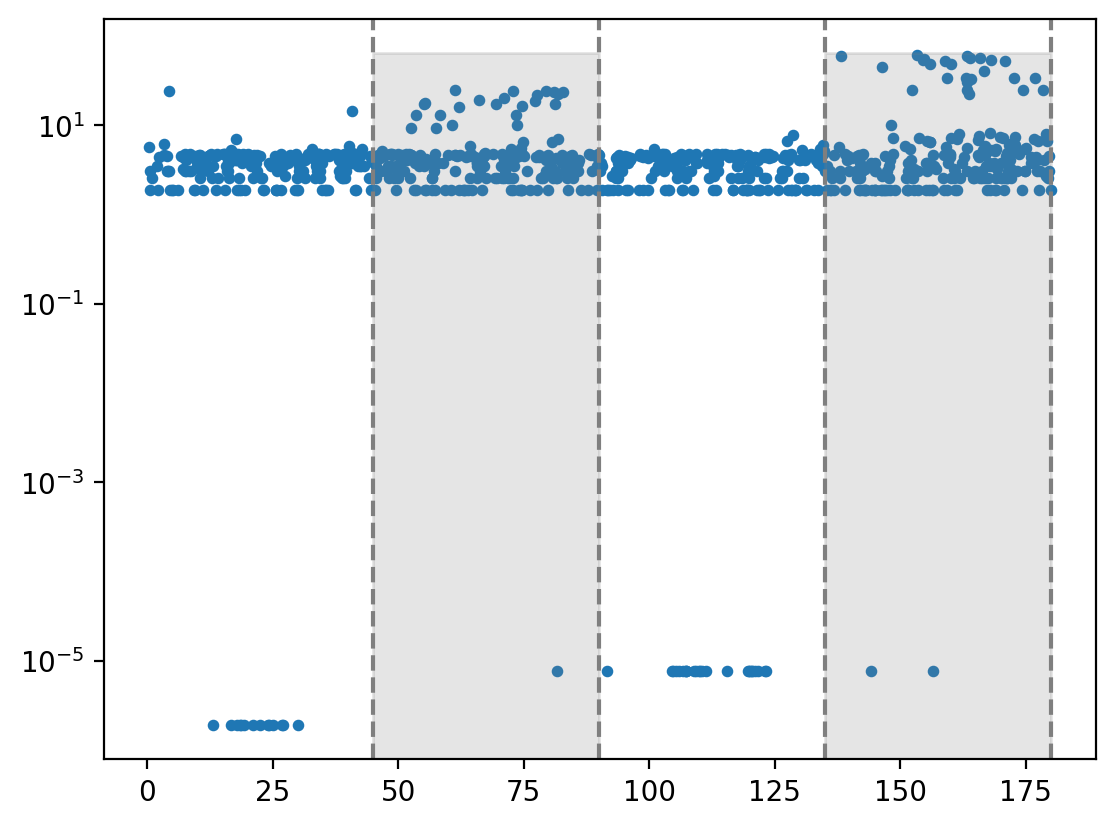

In [690]:
ix_sort = jnp.argsort(y_test)
plt.scatter(y_test[ix_sort], yhat_std[ix_sort], s=10)
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")
plt.yscale("log")

### Evaluating the posterior predictive as a function of rotation angle

In [691]:
ix_target = 0
x_target = np.array(X_test[ix_target]).reshape(28, 28)
y_init = float(y_test[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

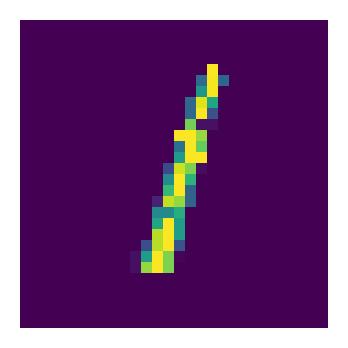

In [692]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x_target.reshape(28, 28))
ax.axis("off");

In [693]:
n_rotations = 360
maxangle = 360
rotations = np.linspace(0, maxangle, n_rotations)
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, maxangle, 100)

In [694]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

In [695]:
logits_test = jax.vmap(state.apply_fn, (0, None))(state.params, X_target)
probs_test = jax.nn.softmax(logits_test, axis=-1)
probs_test.shape

(25, 360, 20)

In [696]:
yhat_mean = bins[probs_test.argmax(axis=-1)].mean(axis=0)
yhat_std = bins[probs_test.argmax(axis=-1)].std(axis=0)

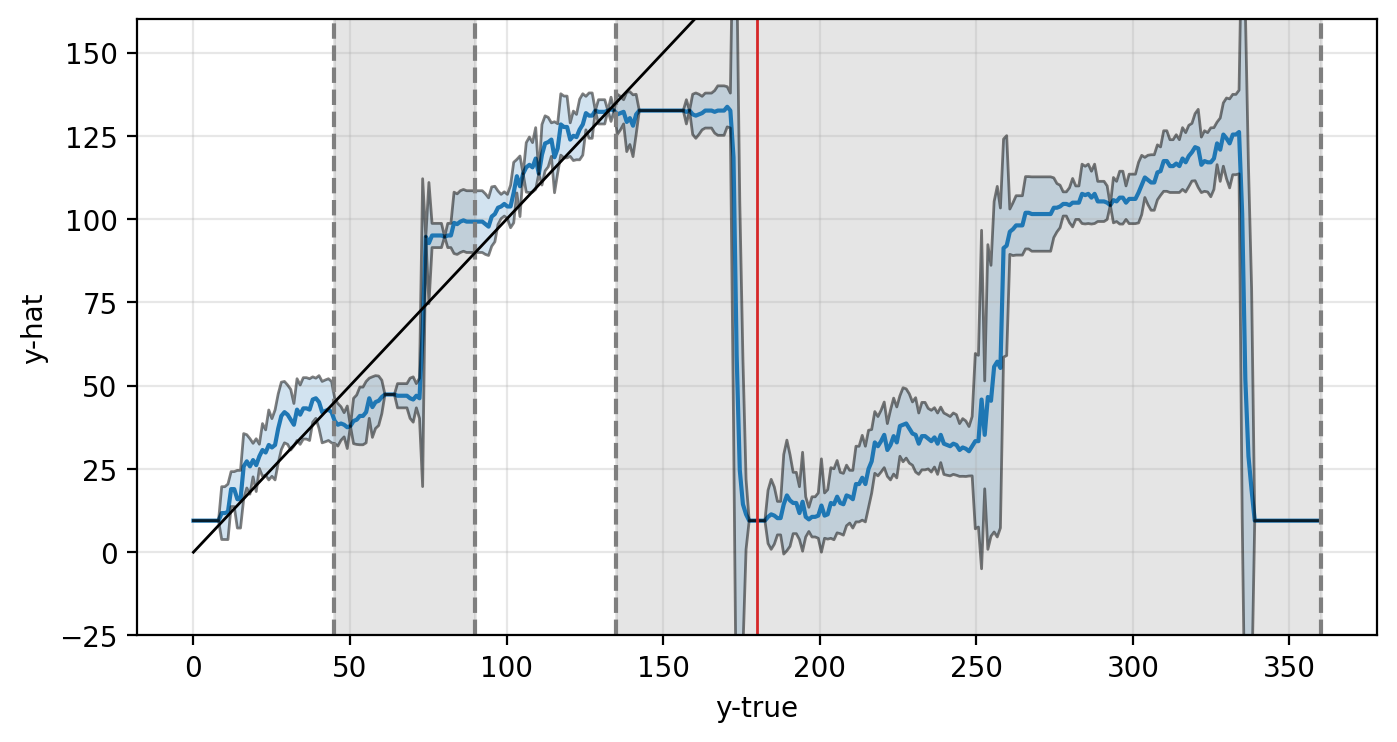

In [697]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=maxangle, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, maxangle], [0, maxangle], c="black", linewidth=1)

plt.ylim(ymin, ymax)
plt.ylim(-25, 160)
plt.axvline(x=180, c="tab:red", linewidth=1)

plt.grid(alpha=0.3)


## Animation

In [291]:
from matplotlib.animation import FuncAnimation

In [292]:
# Trench boundaries
t0_min, t0_max = 45, 90
t1_min, t1_max = 135, 360

CPU times: user 7min 49s, sys: 46.3 s, total: 8min 35s
Wall time: 6min 56s


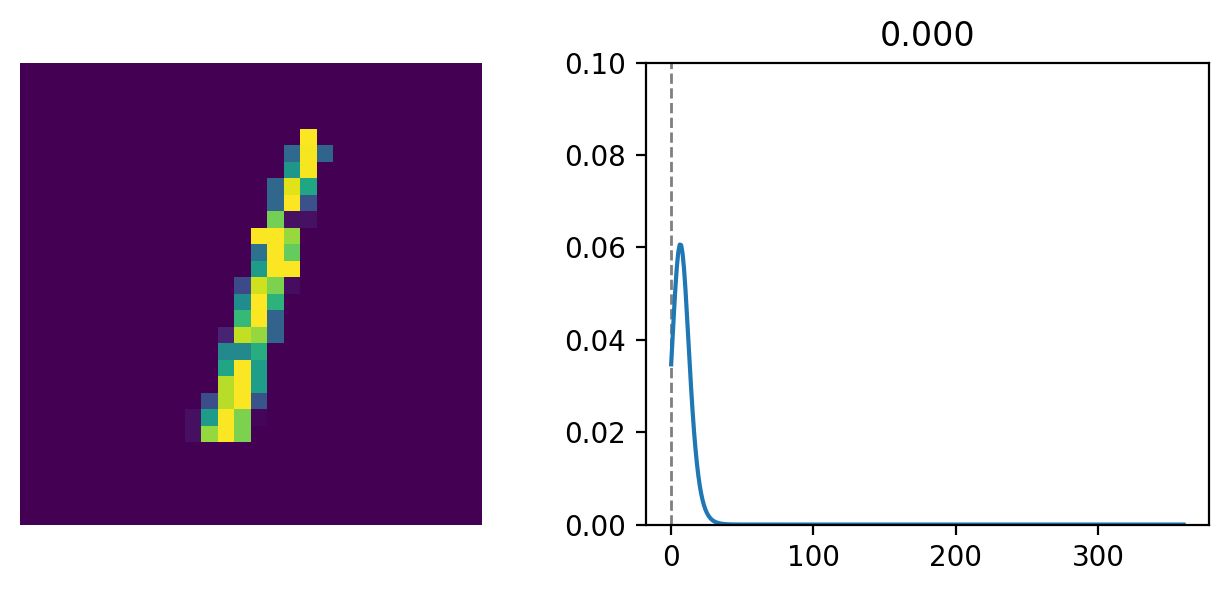

In [293]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

def animate(ix):
    plt.cla()
    rotation = rotations[ix]
    img = np.array(X_target)[ix].reshape(28, 28)
    density = distrax.Normal(loc=yhat_samples[:, ix], scale=std_samples[:, ix]).prob(rotations[:, None]).mean(axis=1)
    density = np.array(density)
    
    axs[0].imshow(img)
    axs[0].axis("off")
    
    if (t0_min < rotation < t0_max) or (t1_min < rotation < t1_max):
        # In trench
        color_rotation = "tab:red"
    else:
        color_rotation = "tab:blue"
    
    axs[1].axvline(x=rotation, color="tab:gray", linestyle="--", linewidth=1)
    axs[1].plot(rotations, density, c=color_rotation)
    axs[1].set_title(f"{rotation:0.3f}")
    axs[1].set_ylim(0, 0.1)
    
    return axs

frames = np.arange(len(rotations))
anim = FuncAnimation(fig, animate, frames=frames)
anim.save("animation-rotating-one-ensemble.mp4", dpi=100, bitrate=-1, fps=20)